### Plan

Phase 1 

1. Take part of the data - 7 million? (5 mil train and 1 mil valid and 1 mil test)?
2. Create features
3. Categorical/Numerical variables
4. Create embedding sizes from categorical variables
5. Make predictions on the original test data using this model trained on just 5 million rows

### Read Libraries

In [1]:
import pandas as pd

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)


In [2]:
from sklearn.metrics import auc

### Read data path

In [3]:
path = '/home/paperspace/data/talkingdata/'

### Read train sample data

In [4]:
train_sample = pd.read_csv(path+'train.csv.zip',compression='zip',low_memory=True,skiprows=184903890-7000000)

In [5]:
train_columns = pd.read_csv(path+'train.csv.zip',compression='zip',low_memory=True,nrows=1)

In [6]:
train_sample.columns = train_columns.columns

In [7]:
train_sample.shape

(7000000, 8)

In [8]:
train_sample['is_attributed'].value_counts()

0    6986062
1      13938
Name: is_attributed, dtype: int64

In [41]:
train_sample['is_attributed'].value_counts()[1]/(train_sample['is_attributed'].value_counts()[0]+train_sample['is_attributed'].value_counts()[1])

0.001991142857142857

In [8]:
df = train_sample.copy()

In [9]:
df.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,90680,9,1,18,489,2017-11-09 13:51:03,NaN,0
1,110563,18,1,13,107,2017-11-09 13:51:03,NaN,0
2,96723,18,1,22,121,2017-11-09 13:51:03,NaN,0
3,124897,15,1,19,3,2017-11-09 13:51:03,NaN,0
4,20820,9,1,13,232,2017-11-09 13:51:03,NaN,0


In [10]:
df = df.reindex()

In [11]:
train_idx = range(round(df.shape[0]*0.8))

In [12]:
val_idx = range(round(df.shape[0]*0.8),round(df.shape[0]*0.8)+round(df.shape[0]*0.1))

In [13]:
test_idx = range(round(df.shape[0]*0.8)+round(df.shape[0]*0.1),df.shape[0])

In [14]:
df.drop(columns='attributed_time',inplace=True)

In [15]:
df['click_time'] = pd.to_datetime(df['click_time'])

In [16]:
df['year'] = df['click_time'].dt.year
df['month'] = df['click_time'].dt.month
df['day'] = df['click_time'].dt.day
df['hour'] = df['click_time'].dt.hour
df['minute'] = df['click_time'].dt.minute
df['second'] = df['click_time'].dt.second
df['day_of_week'] = df['click_time'].dt.dayofweek
df['day_of_year'] = df['click_time'].dt.dayofyear


In [17]:
df.drop(columns='click_time',inplace=True)

In [19]:
#df = df.reindex()

In [20]:
df.head(5)

,ip,app,device,os,channel,is_attributed,year,month,day,hour,minute,second,day_of_week,day_of_year
0,90680,9,1,18,489,0,2017,11,9,13,51,3,3,313
1,110563,18,1,13,107,0,2017,11,9,13,51,3,3,313
2,96723,18,1,22,121,0,2017,11,9,13,51,3,3,313
3,124897,15,1,19,3,0,2017,11,9,13,51,3,3,313
4,20820,9,1,13,232,0,2017,11,9,13,51,3,3,313


In [18]:
cat_vars = ['ip','app','device','os','channel','year','month','day','hour','minute','second','day_of_week','day_of_year']

In [19]:
def proc_col(col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

In [20]:
name2idx =[]
for v in cat_vars:
    _,temp,df[v],_ = proc_col(df[v])
    name2idx.append(temp)

In [89]:
temp

NameError: name 'temp' is not defined

In [21]:
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered().copy()

In [25]:
df.head(5)

,ip,app,device,os,channel,is_attributed,year,month,day,hour,minute,second,day_of_week,day_of_year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,2,2,0,0,0,0,0,0,0,0,0
3,3,2,0,3,3,0,0,0,0,0,0,0,0,0
4,4,0,0,1,4,0,0,0,0,0,0,0,0,0


In [22]:
proc_train = df.loc[list(train_idx)+list(val_idx),:].copy()

In [68]:
max(ip_new)

61521

In [69]:
len(set(proc_train['ip']))

61522

In [58]:
max(proc_train['ip'])

364778

In [75]:
ip_df = pd.Series(ip_new)

In [76]:
ip_df = ip_df.astype('category').cat.as_ordered().copy()

In [77]:
len(ip_df.cat.categories)

61522

In [78]:
len(set(df['ip']))

62805

In [23]:
cat_sz = [(c, len(proc_train[c].cat.categories)+1) for c in cat_vars]

In [24]:
cat_sz

[('ip', 62806),
 ('app', 327),
 ('device', 976),
 ('os', 280),
 ('channel', 174),
 ('year', 2),
 ('month', 2),
 ('day', 2),
 ('hour', 5),
 ('minute', 61),
 ('second', 61),
 ('day_of_week', 2),
 ('day_of_year', 2)]

In [25]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [26]:
emb_szs

[(62806, 50),
 (327, 50),
 (976, 50),
 (280, 50),
 (174, 50),
 (2, 1),
 (2, 1),
 (2, 1),
 (5, 3),
 (61, 31),
 (61, 31),
 (2, 1),
 (2, 1)]

In [31]:
proc_train.head(5)

,ip,app,device,os,channel,is_attributed,year,month,day,hour,minute,second,day_of_week,day_of_year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,2,2,0,0,0,0,0,0,0,0,0
3,3,2,0,3,3,0,0,0,0,0,0,0,0,0
4,4,0,0,1,4,0,0,0,0,0,0,0,0,0


In [27]:
df_model = proc_train.drop(columns='is_attributed')

In [28]:
y = proc_train['is_attributed'].values

In [34]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
df_model.shape

(6300000, 13)

In [29]:
df_model_test = df.loc[test_idx,:].copy()

### fastai student's class

In [41]:
torch.cuda.is_available()

True

### Jeremy's class

In [30]:
md = ColumnarModelData.from_data_frame(path, val_idx, df_model, y.astype(np.int32), cat_flds=cat_vars, bs=128,is_reg=False,test_df=df_model_test)

In [31]:
m = md.get_learner(emb_szs, len(df_model.columns)-len(cat_vars),0.04, 2, [1000,500], [0.001,0.01])
#lr = 1e-3

In [34]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(62806, 50)
    (1): Embedding(327, 50)
    (2): Embedding(976, 50)
    (3): Embedding(280, 50)
    (4): Embedding(174, 50)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
    (7): Embedding(2, 1)
    (8): Embedding(5, 3)
    (9): Embedding(61, 31)
    (10): Embedding(61, 31)
    (11): Embedding(2, 1)
    (12): Embedding(2, 1)
  )
  (lins): ModuleList(
    (0): Linear(in_features=320, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True)
)

In [35]:
m.lr_find(start_lr=1e-5, end_lr=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 231/43750 [00:01<05:49, 124.45it/s, loss=0.2]  

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 37%|███▋      | 15979/43750 [01:51<03:12, 143.89it/s, loss=0.0128] 


In [109]:
import pdb

In [39]:
#pdb.set_trace()
m.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                      
    0      0.003895   0.003531  



[0.003530819462754864]

In [42]:
pred_test = m.predict(True)

In [43]:
len(pred_test)

700000

In [44]:
len(df_model_test.index)

700000

In [45]:
y_test = df.loc[test_idx,:]['is_attributed'].values

In [46]:
len(y_test)

700000

In [47]:
pred_test_index = [np.argmax(i) for i in pred_test]

In [48]:
sum(pred_test_index)

709

In [49]:
sum(pred_test_index)/len(pred_test_index)

0.0010128571428571428

7000000

In [50]:
sum(df['is_attributed'])/len(df)

0.001991142857142857

In [53]:
sum(df_model_test['app'].isin(df_model))

0

In [ ]:
df

In [61]:
auc(np.array(pred_test_index),y_test,reorder=True)

0.5

### Predict on real test data

#### Read test data

In [120]:
test = pd.read_csv(path+'test.csv.zip',compression='zip',low_memory=True)

In [121]:
test.head(5)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [122]:
test.shape

(18790469, 7)

In [123]:
test = test.reindex()

In [124]:
test['click_time'] = pd.to_datetime(test['click_time'])

In [125]:
test['year'] = test['click_time'].dt.year
test['month'] = test['click_time'].dt.month
test['day'] = test['click_time'].dt.day
test['hour'] = test['click_time'].dt.hour
test['minute'] = test['click_time'].dt.minute
test['second'] = test['click_time'].dt.second
test['day_of_week'] = test['click_time'].dt.dayofweek
test['day_of_year'] = test['click_time'].dt.dayofyear


In [126]:
test.drop(columns='click_time',inplace=True)

In [127]:
test.drop(columns='click_id',inplace=True)

In [128]:
test.head(5)

,ip,app,device,os,channel,year,month,day,hour,minute,second,day_of_week,day_of_year
0,5744,9,1,3,107,2017,11,10,4,0,0,4,314
1,119901,9,1,3,466,2017,11,10,4,0,0,4,314
2,72287,21,1,19,128,2017,11,10,4,0,0,4,314
3,78477,15,1,13,111,2017,11,10,4,0,0,4,314
4,123080,12,1,13,328,2017,11,10,4,0,0,4,314


In [ ]:
for v in cat_vars:
    try:
        test[v] = name2idx[cat_vars.index(v)]
    except:
        test

In [131]:
test['ip'].map(lambda x:x[name2idx[0]])

TypeError: 'int' object is not subscriptable

In [111]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 16%|█▋        | 7166/43750 [01:10<05:57, 102.27it/s, loss=0.00995]

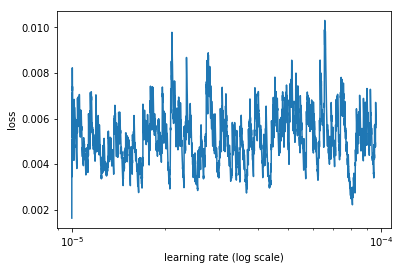

In [117]:
m.sched.plot(1)

> /home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_functions/dropout.py(39)forward()
     37                 ctx.noise.fill_(0)
     38             else:
---> 39                 ctx.noise.bernoulli_(1 - ctx.p).div_(1 - ctx.p)
     40             ctx.noise = ctx.noise.expand_as(input)
     41             output.mul_(ctx.noise)

ipdb> continue


### Other Code

In [47]:
for i in enumerate([10,20,30]):
    print(i)

(0, 10)
(1, 20)
(2, 30)


In [4]:
train = pd.read_csv(path+'train.csv')

In [5]:
train.head(5)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,744519,1,2014-09-03 00:00:00,1,9.096555e+05
1,7627564,1,2014-09-04 00:00:00,1,1.748273e+06
2,7034705,1,2014-09-05 00:00:00,1,NaN
3,5995486,1,2014-09-06 00:00:00,1,NaN
4,7326510,1,2014-09-07 00:00:00,1,NaN


In [6]:
train.shape

(6559830, 5)

In [81]:
submission_format = pd.read_csv(path+'submission_format.csv')

In [8]:
submission_format.head(5)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29 00:00:00,1,0.0
1,5379616,1,2015-08-30 00:00:00,1,0.0
2,496261,1,2015-08-31 00:00:00,1,0.0
3,4567147,1,2015-09-01 00:00:00,1,0.0
4,3684873,1,2015-09-02 00:00:00,1,0.0


In [9]:
submission_format.shape

(1309176, 5)

In [10]:
submission_frequency = pd.read_csv(path+'submission_frequency.csv')

In [11]:
submission_frequency.head(5)

,ForecastId,ForecastPeriodNS
0,1,86400000000000
1,2,86400000000000
2,3,86400000000000
3,4,86400000000000
4,5,3600000000000


In [12]:
submission_frequency.shape

(6974, 2)

In [13]:
weather = pd.read_csv(path+'weather.csv')

In [14]:
weather.head(5)

,Unnamed: 0,Timestamp,Temperature,Distance,SiteId
0,78064,2013-12-31 19:00:00,-7.2,24.889929,1
1,86746,2013-12-31 19:00:00,-8.3,23.303097,1
2,90002,2013-12-31 19:00:00,-7.8,20.952256,1
3,90003,2013-12-31 19:00:00,-8.0,20.952256,1
4,100541,2013-12-31 19:34:00,-8.1,16.610602,1


In [15]:
weather.shape

(20017278, 5)

In [16]:
holidays = pd.read_csv(path+'holidays.csv')

In [17]:
holidays.head(5)

,Unnamed: 0,Date,Holiday,SiteId
0,0,2016-01-01,New year,1
1,1,2016-01-18,"Birthday of Martin Luther King, Jr.",1
2,2,2016-02-15,Washington's Birthday,1
3,3,2016-05-30,Memorial Day,1
4,4,2016-07-04,Independence Day,1


In [18]:
holidays.shape

(8387, 4)

In [19]:
metadata = pd.read_csv(path+'metadata.csv')

In [20]:
metadata.head(5)

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,1,1387.205119,15.0,18.0,False,False,False,False,False,True,True
1,2,6098.278376,30.0,18.0,False,False,False,False,False,True,True
2,3,10556.293605,5.0,18.0,False,False,False,False,False,True,False
3,5,12541.181277,30.0,18.0,False,False,False,False,False,True,True
4,6,9150.195373,30.0,18.0,False,False,False,False,False,True,True


In [21]:
metadata.shape

(267, 11)

In [22]:
### merge train and test sets to perform operations

In [23]:
train['train']=1

In [24]:
submission_format['train']=0

In [25]:
tt_merge = pd.concat([train,submission_format],axis=0)

In [26]:
tt_merge.shape

(7869006, 6)

In [27]:
tt_merge_forecastid = tt_merge.merge(submission_frequency,how='left',left_on='ForecastId',right_on='ForecastId',suffixes=('','_y'))

In [28]:
tt_merge_forecastid['Timestamp'] = pd.to_datetime(tt_merge_forecastid['Timestamp'])

In [29]:
tt_merge_forecastid['year'] = tt_merge_forecastid['Timestamp'].dt.year
tt_merge_forecastid['month'] = tt_merge_forecastid['Timestamp'].dt.month
tt_merge_forecastid['day'] = tt_merge_forecastid['Timestamp'].dt.day
tt_merge_forecastid['hour'] = tt_merge_forecastid['Timestamp'].dt.hour
tt_merge_forecastid['minute'] = tt_merge_forecastid['Timestamp'].dt.minute
tt_merge_forecastid['sec'] = tt_merge_forecastid['Timestamp'].dt.second

In [30]:
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])

In [31]:
weather['year'] = weather['Timestamp'].dt.year
weather['month'] = weather['Timestamp'].dt.month
weather['day'] = weather['Timestamp'].dt.day
weather['hour'] = weather['Timestamp'].dt.hour
weather['minute'] = weather['Timestamp'].dt.minute
weather['sec'] = weather['Timestamp'].dt.second


In [32]:
weather.head(5)

,Unnamed: 0,Timestamp,Temperature,Distance,SiteId,year,month,day,hour,minute,sec
0,78064,2013-12-31 19:00:00,-7.2,24.889929,1,2013,12,31,19,0,0
1,86746,2013-12-31 19:00:00,-8.3,23.303097,1,2013,12,31,19,0,0
2,90002,2013-12-31 19:00:00,-7.8,20.952256,1,2013,12,31,19,0,0
3,90003,2013-12-31 19:00:00,-8.0,20.952256,1,2013,12,31,19,0,0
4,100541,2013-12-31 19:34:00,-8.1,16.610602,1,2013,12,31,19,34,0


In [33]:
weather_grouped = weather.groupby(['SiteId','year','month','day']).agg({'Temperature':'mean','Distance':'mean'}).reset_index()

In [34]:
tt_weather = tt_merge_forecastid.merge(weather_grouped,how='left',left_on=['SiteId','year','month','day'],right_on=['SiteId','year','month','day'],suffixes=("","_y"))

In [35]:
tt_weather[tt_weather['train']==0].shape

(1309176, 15)

In [36]:
tt_weather['date'] = tt_weather['Timestamp'].dt.date

In [37]:
holidays['Date'] = pd.to_datetime(holidays['Date']).copy()

In [38]:
holidays['year'] = holidays['Date'].dt.year
holidays['month'] = holidays['Date'].dt.month
holidays['day'] = holidays['Date'].dt.day


In [39]:
hols_grouped = holidays.groupby(['SiteId','Date']).agg({'Holiday':'first','year':'first','month':'first','day':'first'}).reset_index()

In [40]:
tt_wtr_hol = tt_weather.merge(hols_grouped,how='left',left_on=['SiteId','year','month','day'],right_on=['SiteId','year','month','day'],suffixes=("","_y"))

In [41]:
tt_wtr_hol[tt_wtr_hol['train']==0].shape

(1309176, 18)

In [42]:
tt_wtr_hol_md = tt_wtr_hol.merge(metadata,how='left',left_on='SiteId',right_on='SiteId',suffixes=("","_y"))

In [43]:
tt_wtr_hol_md['dayofweek'] = tt_wtr_hol_md['Timestamp'].dt.dayofweek
tt_wtr_hol_md['dayofyear'] = tt_wtr_hol_md['Timestamp'].dt.dayofyear


In [44]:
tt_wtr_hol_md.head(5)

,obs_id,SiteId,Timestamp,ForecastId,Value,train,ForecastPeriodNS,year,month,day,...,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,dayofweek,dayofyear
0,744519,1,2014-09-03,1,9.096555e+05,1,86400000000000,2014,9,3,...,18.0,False,False,False,False,False,True,True,2,246
1,7627564,1,2014-09-04,1,1.748273e+06,1,86400000000000,2014,9,4,...,18.0,False,False,False,False,False,True,True,3,247
2,7034705,1,2014-09-05,1,NaN,1,86400000000000,2014,9,5,...,18.0,False,False,False,False,False,True,True,4,248
3,5995486,1,2014-09-06,1,NaN,1,86400000000000,2014,9,6,...,18.0,False,False,False,False,False,True,True,5,249
4,7326510,1,2014-09-07,1,NaN,1,86400000000000,2014,9,7,...,18.0,False,False,False,False,False,True,True,6,250


In [45]:
tt_wtr_hol_md['IsHoliday'] = tt_wtr_hol_md['Holiday'].apply(lambda x:0 if pd.isnull(x) else 1)

In [46]:
tt_wtr_hol_md.columns

Index(['obs_id', 'SiteId', 'Timestamp', 'ForecastId', 'Value', 'train',
       'ForecastPeriodNS', 'year', 'month', 'day', 'hour', 'minute', 'sec',
       'Temperature', 'Distance', 'date', 'Date', 'Holiday', 'Surface',
       'Sampling', 'BaseTemperature', 'MondayIsDayOff', 'TuesdayIsDayOff',
       'WednesdayIsDayOff', 'ThursdayIsDayOff', 'FridayIsDayOff',
       'SaturdayIsDayOff', 'SundayIsDayOff', 'dayofweek', 'dayofyear',
       'IsHoliday'],
      dtype='object')

In [47]:
cat_vars = ['SiteId', 'year', 'month', 'day', 'hour', 'minute', 'sec','Holiday','MondayIsDayOff',
       'TuesdayIsDayOff', 'WednesdayIsDayOff', 'ThursdayIsDayOff',
       'FridayIsDayOff', 'SaturdayIsDayOff', 'SundayIsDayOff', 'dayofweek',
       'dayofyear', 'IsHoliday']
contin_vars = ['ForecastPeriodNS','Temperature', 'Distance','Surface', 'Sampling', 'BaseTemperature']

In [48]:
proc_train = tt_wtr_hol_md[tt_wtr_hol_md['train']==1].copy()
proc_test = tt_wtr_hol_md[tt_wtr_hol_md['train']==0].copy()

In [49]:
proc_train.index = proc_train['date']

In [50]:
proc_test.index = proc_test['date']

In [51]:
proc_test.shape

(1309176, 31)

In [52]:
proc_train = proc_train[-((proc_train['Value'].isnull())|(proc_train['Value']==0))].copy()

In [53]:
proc_train.shape

(6472634, 31)

In [54]:
for v in cat_vars: 
    proc_train[v] = proc_train[v].astype('category').cat.as_ordered().copy()
    proc_test[v] = proc_test[v].astype('category').cat.as_ordered().copy()

In [55]:
for v in contin_vars:
    proc_train[v] = proc_train[v].astype('float32')
    proc_test[v] = proc_test[v].astype('float32')

In [56]:
proc_train = proc_train[cat_vars+contin_vars+['Value']]
proc_test = proc_test[cat_vars+contin_vars+['Value']]

### Real Deal

In [57]:
df, y, nas, mapper = proc_df(proc_train, 'Value', do_scale=True)
yl = np.log(y)

In [58]:
df_test, _, nas, mapper = proc_df(proc_test, 'Value', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [59]:
df_test.shape

(1309176, 26)

In [60]:
val_idx = np.flatnonzero(
    (df.index<=datetime.date(2015,11,19)) & (df.index>=datetime.date(2015,11,2)))

In [61]:
val_idx

array([    357,     358,     359,     360,     361,     362,     363,     364,     365,     366,     367,
           368,     369,     370,     371,     372,     373,     374,   21605,   21606, ..., 6472614,
       6472615, 6472616, 6472617, 6472618, 6472619, 6472620, 6472621, 6472622, 6472623, 6472624, 6472625,
       6472626, 6472627, 6472628, 6472629, 6472630, 6472631, 6472632, 6472633])

In [62]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [63]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [64]:
cat_sz = [(c, len(proc_train[c].cat.categories)+1) for c in cat_vars]

In [65]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [66]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [173]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▉    | 29460/49948 [04:20<03:00, 113.20it/s, loss=1.58] 

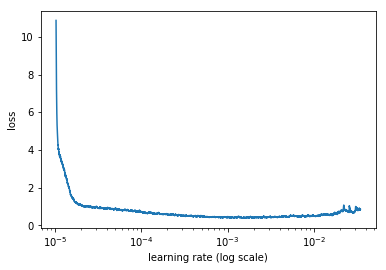

In [174]:
m.sched.plot(100)

In [67]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.247922   0.684131   2.39178   
    1      0.251817   0.637423   2.432638                         
    2      0.213264   0.601745   1.850215                         



[0.60174483, 1.8502146993026323]

In [68]:
pred_test = m.predict(True)

In [69]:
pred_test = np.exp(pred_test)

In [70]:
len(pred_test)

1309176

In [182]:
len(submission_format)

1309176

In [82]:
submission_format['Value'] = pred_test

In [85]:
submission_format.to_csv('submission_format.csv',index=False)

In [86]:
submission_format

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29 00:00:00,1,2.878997e+06
1,5379616,1,2015-08-30 00:00:00,1,3.361612e+06
2,496261,1,2015-08-31 00:00:00,1,5.077796e+06
3,4567147,1,2015-09-01 00:00:00,1,4.834590e+06
4,3684873,1,2015-09-02 00:00:00,1,5.112801e+06
5,4698291,1,2015-09-03 00:00:00,1,5.013370e+06
6,1129255,1,2015-09-04 00:00:00,1,4.745319e+06
7,834539,1,2015-09-05 00:00:00,1,3.135379e+06
8,3293948,1,2015-09-06 00:00:00,1,3.151302e+06
9,5460161,1,2015-09-07 00:00:00,1,5.094661e+06


### Trying to create input x

In [32]:
embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])

In [45]:
embs[0]

Embedding(62806, 50)

In [46]:
cat_sz

[('ip', 62806),
 ('app', 327),
 ('device', 976),
 ('os', 280),
 ('channel', 174),
 ('year', 2),
 ('month', 2),
 ('day', 2),
 ('hour', 5),
 ('minute', 61),
 ('second', 61),
 ('day_of_week', 2),
 ('day_of_year', 2)]

In [33]:
for emb in embs: emb_init(emb)

In [34]:
n_emb = sum(e.embedding_dim for e in embs)

In [35]:
x = [e(x_cat[:,i]) for i,e in enumerate(embs)]

NameError: name 'x_cat' is not defined

In [37]:
cat_vars

['ip',
 'app',
 'device',
 'os',
 'channel',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'day_of_week',
 'day_of_year']

In [43]:
len([c.values for n,c in train_sample.items()][0])

7000000

In [42]:
train_sample

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,90680,9,1,18,489,2017-11-09 13:51:03,NaN,0
1,110563,18,1,13,107,2017-11-09 13:51:03,NaN,0
2,96723,18,1,22,121,2017-11-09 13:51:03,NaN,0
3,124897,15,1,19,3,2017-11-09 13:51:03,NaN,0
4,20820,9,1,13,232,2017-11-09 13:51:03,NaN,0
5,106435,12,1,13,497,2017-11-09 13:51:03,NaN,0
6,40289,9,1,16,334,2017-11-09 13:51:03,NaN,0
7,5348,14,1,19,489,2017-11-09 13:51:03,NaN,0
8,53454,12,1,19,409,2017-11-09 13:51:03,NaN,0
9,15490,6,1,13,459,2017-11-09 13:51:03,NaN,0
